In [1]:
import os
import json
import skimage
import shutil
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

%cd /opt/cresi
from cresi import create_8bit_images, config as config_mdl

/opt/cresi


### Set config path

In [2]:

cresi_dir = '/opt/cresi'

config_dir = os.path.join(cresi_dir, 'cresi', 'configs')
config_filename = 'demo_config.json'

config_path = os.path.join(config_dir, config_filename)

In [3]:
with open(config_path, "r") as f:
    cfg = json.load(f)
    config = config_mdl.Config(**cfg)

In [4]:
raw_data_dir = os.path.join(config.path_data_root, config.raw_data_dir)
eight_bit_dir = os.path.join(config.path_data_root, config.eight_bit_dir)
sliced_dir = os.path.join(config.path_data_root, config.sliced_dir)
folds_save_dir = os.path.join(config.path_results_root, config.folds_save_dir)
stitched_dir_norm = os.path.join(config.path_results_root, config.stitched_dir_norm)

results_dir = config.path_results_root

### Clear previous results

In [ ]:
for f in os.listdir(eight_bit_dir):
    os.remove(os.path.join(eight_bit_dir, f))
    
for f in os.listdir(sliced_dir):
    os.remove(os.path.join(sliced_dir, f))
    
for f in os.listdir(results_dir):
    try:
        os.remove(os.path.join(results_dir, f))
    except:
        shutil.rmtree(os.path.join(results_dir, f))

### Convert 16bit MS to 8bit, 3 band

In [ ]:
#import rasterio 
"""
for im_name in os.listdir(test_im_clip_dir):
    break
    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))

    n_ds = rasterio.open(
        os.path.join(test_final_dir, im_name),
        'w',
        driver='GTiff',
        height=ds.shape[0],
        width=ds.shape[1],
        count=3, # 3 bands
        dtype='uint8', # 8 bit
        crs=ds.crs, # copy from orig
        transform=ds.transform # lonlat bounds, copy from orig
    )
    
    # 3 band orig
    if len(ds.dtypes) == 3:
        n_ds.write_band(1, ds.read(1).astype('uint8'))
        n_ds.write_band(2, ds.read(2).astype('uint8'))
        n_ds.write_band(3, ds.read(3).astype('uint8'))
    elif len(ds.dtypes) == 8:
        n_ds.write_band(1, ds.read(5).astype('uint8'))
        n_ds.write_band(2, ds.read(3).astype('uint8'))
        n_ds.write_band(3, ds.read(2).astype('uint8'))
    else:
        print ('Unknown source type.')
    
    n_ds.close()
"""
 

In [ ]:
# this works much better, but we can't use gdal 
from cresi import create_8bit_images

# Convert 16-bit multispectral test data to 8-bit RGB
create_8bit_images.dir_to_8bit(raw_data_dir, eight_bit_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

In [ ]:
# display our image
im_name = [z for z in os.listdir(eight_bit_dir) if z.endswith('.tif')][0]
im_path = os.path.join(eight_bit_dir, im_name)
im = skimage.io.imread(im_path)

skimage.io.imshow(im) 
skimage.io.show()

### Slice image into processable chunks
slice_x, slice_y defined in config

In [ ]:
%run -i cresi/01_slice.py { config_path }

### Run Inference

In [ ]:
%run -i cresi/02_eval.py { config_path }

### Evaluate results

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

In [ ]:
mask_pred_file = [z for z in os.listdir(folds_save_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(folds_save_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

### Stitch slices back together

In [ ]:
%run -i cresi/03_stitch.py { config_path }

In [ ]:
# Inspect the output
mask_pred_file = [z for z in os.listdir(stitched_dir_norm) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(stitched_dir_norm, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

In [ ]:
%run -i cresi/04_skeletonize.py { config_path }

In [19]:
%run -i cresi/05_wkt_to_G.py { config_path }

image_ids: ['000-001-RGB']
len image_ids: 1
000-001-RGB
im_file: /opt/cresi/data/raw_data/000-001-RGB.tif
Computing geo coords for nodes (12 threads)...
Updating data properties
params_tmp ('tmp', 2997.0, 6.0, '/opt/cresi/data/raw_data/000-001-RGB.tif')
tmp_dict: {'tmp': (23.930517461012105, 49.823720907985916)}
Computing geo coords for edges (12 threads)...
Updating edge data properties


/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0 10003 10048
0 10003 10048
0 10003 10048
0 10003 10048


/opt/conda/lib/python3.8/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
/opt/conda/lib/python3.8/site-packages/osmnx/io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


Time to run wkt_to_G.py: 3.049278974533081 seconds


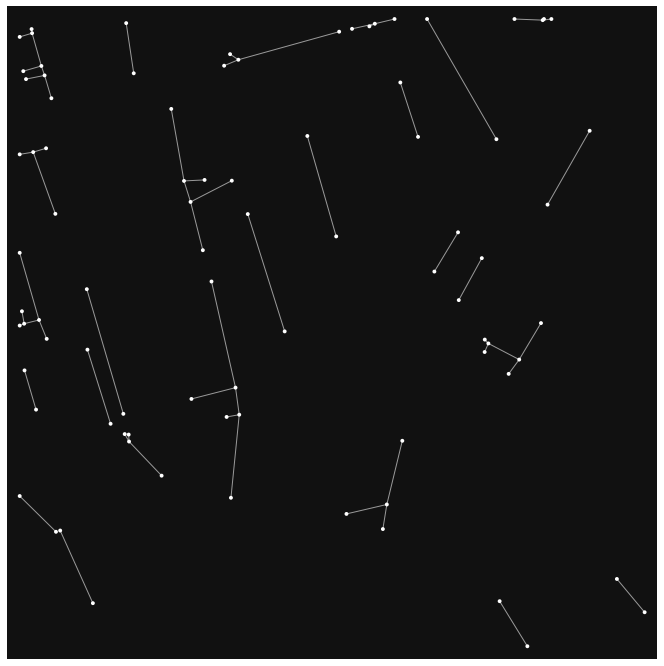

In [20]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))